# Hedging Options

## Introduction

In this notebook we will follow the [PyQuant article](https://www.pyquantnews.com/the-pyquant-newsletter/establish-simple-delta-hedge-actually-works-python) about hedging options to hedge a hypothetical option.

First lets define some definitions for options:

* **Option:** An option is a financial derivative that gives the buyer the right to buy (or sell) an underlying asset at a agreed upon price and date. The price of an option (strike price) is derived from the price of the underlying asset, hence it being called a derivative.
* **Call Option:** A Call Option gives a buyer the right to buy an asset at a specific price within a specfic time frame.
* **Put Option:** A Put Option gives the buyer the right to sell an asset at a stated price within a specific price range.
* **Strike Price:** The strike price is the stated price which a buyer has the right (but not the obligation) to buy or sell the asset
* **Hedging:** Hedging refers to the mitigation of risk when holding an asset. This can be applied to transactions outside of derivatives. Typically, options are used as a hedge against a stock price or portfolio return drop. They essentially act as a cover to minimize loss.

An example of hedging is insurance. When you take out a policy on something (i.e. car, house, etc.) you are mitigating the risk of loss/damage to the item. In investing, you are making investments that have negative correlation - if one succeeds the other will falter. For instance, if your porfolio is positioned for the success of companies A, B, and C, then buying put options againsts those companies would be an affective hedge of risk on that portfolio.

## Importing Modules

To start we are going to import the *QuantLib* package for python (documentation found here: https://quantlib-python-docs.readthedocs.io/en/latest/index.html) 

In [1]:
import QuantLib as ql

## Setting up the Option

After importing *QuantLib*, we can set up the option parameters:

In [2]:
today = ql.Date(24, 1, 2024)
ql.Settings.instance().evaluationDate = today

expiry = ql.Date(24, 6, 2024)
strike_price = 90
option_type = ql.Option.Call

payoff = ql.PlainVanillaPayoff(option_type, strike_price)
exercise = ql.EuropeanExercise(expiry)
european_option = ql.VanillaOption(payoff, exercise)

Above, we defined the evaluation date of the Option, set a expiration date for the option, the strike price (price that the buyer agrees to buy the option at), and the type of option (a call in this case hence using "buy" in the previous definition). We then set up the payoff format, the style it will be executed under, and then created the option.

## Setting up the Market Conditions

Next, we will define the market conditions under which this option exists:

In [3]:
spot_price = 90
volatility = 0.2
dividend_rate = 0.01
risk_free_rate = 0.05

spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
volatility_handle = ql.BlackVolTermStructureHandle(
    ql.BlackConstantVol(
        today, 
        ql.NullCalendar(), 
        ql.QuoteHandle(ql.SimpleQuote(volatility)), 
        ql.Actual365Fixed()
    )
)
dividend_handle = ql.YieldTermStructureHandle(
    ql.FlatForward(
        today,
        ql.QuoteHandle(ql.SimpleQuote(dividend_rate)),
        ql.Actual365Fixed()
    )
)
risk_free_handle = ql.YieldTermStructureHandle(
    ql.FlatForward(
        today,
        ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)),
        ql.Actual365Fixed()
    )
)

bsm_process = ql.BlackScholesMertonProcess(
    spot_handle,
    dividend_handle,
    risk_free_handle,
    volatility_handle
)

european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
option_price = european_option.NPV()
print("Option Price : {:.2f}".format(option_price))

Option Price : 5.35


In the above code block we:
* Set the **Spot Price**. The spot price refers to the price of the market value of the underlying asset the option is dealing with. 
* Set the **Volatility** parameter. The volatility is a estimation of the prices volatility in the current market. We set this to be 20%. What this is telling us is that over the next 12-months, a one-standard deviation move in the stock will be +/- 18$ (20% of the Spot Price).
* Set the **Dividend Rate**. The dividend rate is the percentage in dividends a company pays out each year. A dividend is a percentage of a companies earnings that are paid out to investors as a share of their profit. The dividend rate defines the percentage paid. Typically companies doing well will pay dividends.
* Set the **Risk-Free Rate** parameter. The risk-free rate tells us what the rate of return on an investment is with zero probability of loss. It is often calculated using the inflation rate and the yield from a US treasury bond with the same duration as the investment.

After defining these parameters, we then create handles from them using the *QuantLib.QuoteHandle* class, allowing us to pass it into a model calculation. To calculate the price of our option, we use the **BlackScholesMertonProcess**. We define the model given our parameter handles defined above, and set it as a method for our European option. We then call the *NPV* method, which calculates the *Net Present Value* of the option given the parameters we provided.

### The Black-Scholes-Merton Equation (A Sidebar)

The **Black-Scholes-Merton** equation is a partial differential equation defined as:

$$
\frac{\partial{V}}{\partial{t}} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^2{V}}{\partial{S^2}} = rV - rS\frac{\partial{V}}{\partial{S}},
$$

where $V$ is the price of an option as a function of the current asset price $S$ and time $t$, $r$ is the risk-free rate, and $\sigma$ is the volatility of the stock. The underlying assumption is that in a frictionless market, one can buy or sell the asset in question for a given option to eliminate the risk associated with the option. This process is known as hedging.

From this equation one can get the price of a call option (defined in the introductory section)

$$
C = SN(d_1) - Ke^{(-rt)}N(d_2),
$$

where $C$ is the call option price, $S$ is the current stock price, $N$ is the normal distribution, $K$ is the strike price, $r$ is the risk-free rate, and $t$ is the time to maturity. The variable $d_1$ is represented by the equation 

$$
d_1 = \frac{ln(\frac{S}{K}) + (r \frac{\sigma^{2}_{v}}{2})t}{\sigma_s\sqrt{t}}
$$

while $d_2$ is represented by the equation:

$$
d_2 = d_1 - \sigma_s\sqrt{t}
$$

Both $d_1$ and $d_2$ are probability function, and $\sigma_s$ is the implied volatility of the asset.

From [investopedia](https://www.investopedia.com/terms/b/blackscholes.asp), the benefits of the Black-Scholes model are:
* Provides a framework for pricing options. Allows for standard method that has been tried-and-tested.
* Allows for risk management of various assets by understanding the theoretical price of an option.
* Allows for portfolio optimization by providing a thoeretical measure of return and risks associated with different options.
* Has led to greater market efficiency and transparency for investor and traders.

With all benefits come the corresponding limitations. For the Black-Scholes model:
* The model is only used for pricing European options in practice. It cannot account for the fact that American options can be executed prior to the expiration date.
* While it accounts for dividend-rates and risk-free rates, the model assumes these to be static over the period of holding, so it cannot account for future cash flow accurately.
* Similar to above, while it is able to account for volatility, it assumes constant volatility over the holding period, not accounting for changes in supply-and-demand.
* There are a series of other assumptions that are made that will lead to slight deviations in the forecasted price to the actual price at some future time $t_{future}$.

## Calculating the Delta of the Option

In options, there are four defined *Greeks* (see [invetopedia page](https://www.investopedia.com/trading/getting-to-know-the-greeks/) for full deinfitions):

* $\Delta$: refers to the option price's sensitivity to changes in the underlying asset. The range of the $\Delta$ of an option is [-1, 0] for a put and [0, 1] for a call. A call, for example, generates a positive delta because it is positively correlated with the underlying asset price: if the asset increases so does the option price, and if the underlying asset price decreases so does the option price.
* $\Gamma$: refers to the measurement of the rate of change of $\Delta$. While $\Delta$ is a varying variable, $\Gamma$ is a constant. It can be thought of a measure of the stability of the option's probability.
* $\Theta$: refers to the time of decay in an option's value. $\Theta$ is always negative, and the time to decay accelerates as the expiration date of the option gets closer. This is because the there is less time to execute the option and profit from it.
* $\nu$: refers to the risk of changes in tge underlying assets implied volatility. It can approximate the increase or decrease in an options's price based on an increase or decrease in the implied volatility. Here, those holding calls benefit from a rise in implied volatility while put holders lose value.

For this exercise, we will focus on $\Delta$. We can represent the value of $\Delta$ as follows:

$$
\Delta = \frac{O_f - O_i}{S_f - S_i},
$$

where $O_f$ is the option's current price, $O_i$ is the option's initial price, $S_f$ is the underlying asset's current price, and $S_i$ is the underlying asset's initial price. The QuantLib package has a simple method for options, once they have been created, to calculate the $\Delta$ of it:

In [4]:
delta = european_option.delta()
print("\u0394 of Option : {:.2f}".format(delta))

Δ of Option : 0.57


The $\Delta$ tells us how much of the underlying asset we need to hold in order to effectively hedge our holding.

## Implementing Hedging Strategy
Knowing the options delta given market parameteres, we can now implement a strategy to combat the chnage in price in our portfolio. Below is the code to hedge our position:

In [5]:
stock_position = delta * spot_price
print("Initial stock position : {:.2f}".format(stock_position))

spot_handle = ql.QuoteHandle(ql.SimpleQuote(new_spot_price))

bsm_process = ql.BlackScholesMertonProcess(
    spot_handle,
    dividend_handle,
    risk_free_handle,
    volatility_handle
)

european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
new_option_price = european_option.NPV()
new_delta = european_option.delta()
print("New Option Price : {:.2f}".format(new_option_price))
print("New \u0394 : {:.2f}".format(new_delta))

new_stock_position = new_delta * new_spot_price
hedge_adjustment = new_stock_position - stock_position
print("Adjustment in Stock Position : {:.2f}".format(hedge_adjustment))

Initial stock position : 51.69


NameError: name 'new_spot_price' is not defined

In the block above, we first calculate the stock price required to hedge the option. We then look at a change in the spot price and update our option model to calculate the new option price as a result in the shift, as well as the new $\Delta$. Using the two, we can then calculate the new position required to hedge the option, and calculate the hedge amount by subtracting the new position from the old.

# Exploring

Lets now change some of our parameters to see how this strategy changes. First, we are going to right a function to handle the process for us:

In [6]:
def hedge_calc(init_date: ql.QuantLib.Date, expiry_date: ql.QuantLib.Date, strike_price: float, spot_price: float, volatility: float, risk_free_rate: float, dividend_rate: float, new_spot_price: float) -> (float, float, float, float, float):
    
    ql.Settings.instance().evaluationDate = init_date
    
    option_type = ql.Option.Call

    payoff = ql.PlainVanillaPayoff(option_type, strike_price)
    exercise = ql.EuropeanExercise(expiry_date)
    european_option = ql.VanillaOption(payoff, exercise)
    
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    volatility_handle = ql.BlackVolTermStructureHandle(
        ql.BlackConstantVol(
            today, 
            ql.NullCalendar(), 
            ql.QuoteHandle(ql.SimpleQuote(volatility)), 
            ql.Actual365Fixed()
        )
    )
    dividend_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(
            today,
            ql.QuoteHandle(ql.SimpleQuote(dividend_rate)),
            ql.Actual365Fixed()
        )
    )
    risk_free_handle = ql.YieldTermStructureHandle(
        ql.FlatForward(
            today,
            ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)),
            ql.Actual365Fixed()
        )
    )

    bsm_process = ql.BlackScholesMertonProcess(
        spot_handle,
        dividend_handle,
        risk_free_handle,
        volatility_handle
    )

    european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    option_price = european_option.NPV()
    
    delta = european_option.delta()
    
    stock_position = delta * spot_price

    spot_handle = ql.QuoteHandle(ql.SimpleQuote(new_spot_price))

    bsm_process = ql.BlackScholesMertonProcess(
        spot_handle,
        dividend_handle,
        risk_free_handle,
        volatility_handle
    )

    european_option.setPricingEngine(ql.AnalyticEuropeanEngine(bsm_process))
    new_option_price = european_option.NPV()
    new_delta = european_option.delta()
    
    new_stock_position = new_delta * new_spot_price
    hedge_adjustment = new_stock_position - stock_position
    
    return option_price, delta, new_option_price, new_delta, hedge_adjustment

## Calculating Relationships with Market Conditions 

Now that we have created our function, lets first look at how the calculated option price, delta, and hedge adjustment change with varying market conditions. Specifically, we will adjust the risk-free rate and the implied volatility of the asset. We define the implied volatility to be in the range of [0, 0.5] and the risk-free rate to be in the range of [0, 0.1]. The values will be iterated over, saving the desired variables to their respective array.

In [7]:
import numpy as np

strike_price = 90
new_spot_price = 95
today = ql.Date(24, 1, 2024)
expiry_date = ql.Date(24, 6, 2024)

spot_price = 90
volatility = np.linspace(0,0.5,101)
dividend_rate = 0.01
risk_free_rate = np.linspace(0,0.1,101)

option_price_arr = np.empty((101,101), dtype=float)
delta_arr = np.empty((101,101), dtype=float)
new_option_price_arr = np.empty((101,101), dtype=float)
new_delta_arr = np.empty((101,101), dtype=float)
hedge_adjustment_arr = np.empty((101,101), dtype=float)
volatility_arr = np.empty((101,101), dtype=float)
rfr_arr = np.empty((101,101), dtype=float)

for i in range(101):
    for j in range(101):
        option_price_arr[i,j], delta_arr[i,j], new_option_price_arr[i,j], new_delta_arr[i,j], hedge_adjustment_arr[i,j] = hedge_calc(today, expiry_date, strike_price, spot_price, volatility[i], risk_free_rate[j], dividend_rate, new_spot_price)
        volatility_arr[i,j] = volatility[i]
        rfr_arr[i,j] = risk_free_rate[j]
        
        
        
        

## Plotting the Results
Having written our function, the relationship between the option price, delta, new option price, new delta, hedging position and the implied volitility and risk-free rate can be explored visually.

### Scatter Plots
We first can look at the individual relationships of volatility and the risk-free rate with the output variables of our function. To do this, we first construct a *pandas* DataFrame holding the simulated data and inputs. We then create two DataFrames, one with the volatility held constant at a value of our choosing, and one with the risk-free rate hold constant at a value of our choosing:

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(
    {
        "option_price": np.squeeze(np.reshape(option_price_arr, (-1,1))),
        "delta": np.squeeze(np.reshape(delta_arr, (-1,1))),
        "new_option_price": np.squeeze(np.reshape(new_option_price_arr, (-1,1))),
        "new_delta": np.squeeze(np.reshape(new_delta_arr, (-1,1))),
        "hedge_adj": np.squeeze(np.reshape(hedge_adjustment_arr, (-1,1))),
        "volatility": np.squeeze(np.reshape(volatility_arr, (-1,1))),
        "risk_free_rate": np.squeeze(np.reshape(rfr_arr, (-1,1)))
    }
)

df_vol = df[df['risk_free_rate']==0.01]
df_rfr = df[df['volatility']==0.2]

After creating the DataFrames, we can use the *scatter* method from *matplotlib* to display the data as functions of volatility and risk-free-rate:

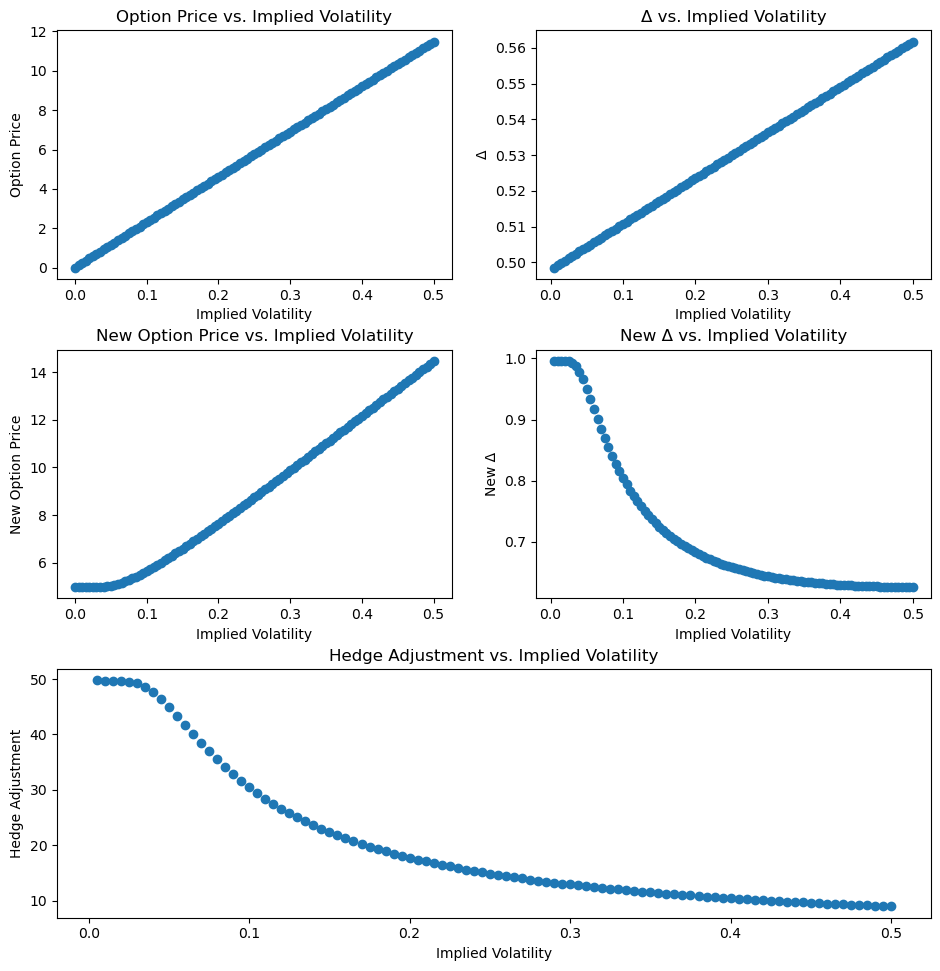

In [9]:
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

fig.tight_layout(pad=3)

_ = ax1.scatter(x='volatility', y='option_price', data=df_vol)
_ = ax1.set_xlabel('Implied Volatility')
_ = ax1.set_ylabel('Option Price')
_ = ax1.set_title('Option Price vs. Implied Volatility')

_ = ax2.scatter(x='volatility', y='delta', data=df_vol)
_ = ax2.set_xlabel('Implied Volatility')
_ = ax2.set_ylabel('\u0394')
_ = ax2.set_title('\u0394 vs. Implied Volatility')

_ = ax3.scatter(x='volatility', y='new_option_price', data=df_vol)
_ = ax3.set_xlabel('Implied Volatility')
_ = ax3.set_ylabel('New Option Price')
_ = ax3.set_title('New Option Price vs. Implied Volatility')

_ = ax4.scatter(x='volatility', y='new_delta', data=df_vol)
_ = ax4.set_xlabel('Implied Volatility')
_ = ax4.set_ylabel('New \u0394')
_ = ax4.set_title('New \u0394 vs. Implied Volatility')

_ = ax5.scatter(x='volatility', y='hedge_adj', data=df_vol)
_ = ax5.set_xlabel('Implied Volatility')
_ = ax5.set_ylabel('Hedge Adjustment')
_ = ax5.set_title('Hedge Adjustment vs. Implied Volatility')

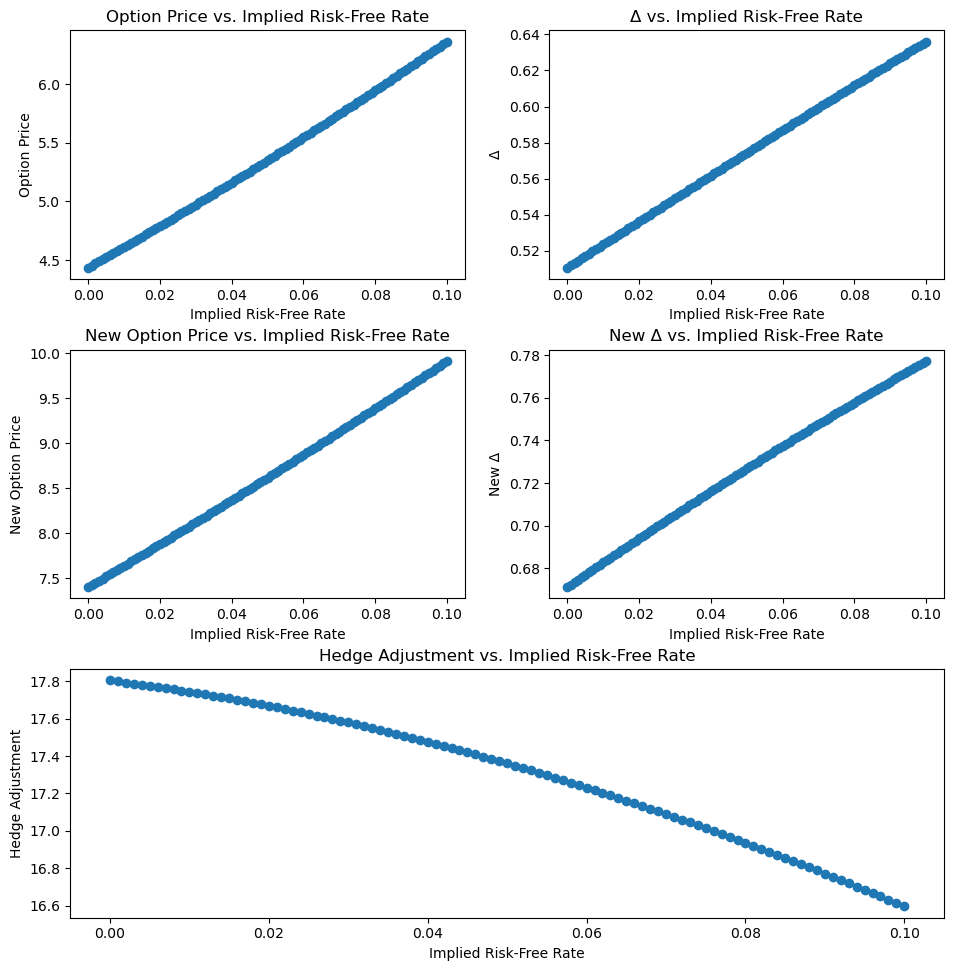

In [10]:
fig = plt.figure(figsize=(10,10))

gs = fig.add_gridspec(3,2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[2, :])

fig.tight_layout(pad=3)

_ = ax1.scatter(x='risk_free_rate', y='option_price', data=df_rfr)
_ = ax1.set_xlabel('Implied Risk-Free Rate')
_ = ax1.set_ylabel('Option Price')
_ = ax1.set_title('Option Price vs. Implied Risk-Free Rate')

_ = ax2.scatter(x='risk_free_rate', y='delta', data=df_rfr)
_ = ax2.set_xlabel('Implied Risk-Free Rate')
_ = ax2.set_ylabel('\u0394')
_ = ax2.set_title('\u0394 vs. Implied Risk-Free Rate')

_ = ax3.scatter(x='risk_free_rate', y='new_option_price', data=df_rfr)
_ = ax3.set_xlabel('Implied Risk-Free Rate')
_ = ax3.set_ylabel('New Option Price')
_ = ax3.set_title('New Option Price vs. Implied Risk-Free Rate')

_ = ax4.scatter(x='risk_free_rate', y='new_delta', data=df_rfr)
_ = ax4.set_xlabel('Implied Risk-Free Rate')
_ = ax4.set_ylabel('New \u0394')
_ = ax4.set_title('New \u0394 vs. Implied Risk-Free Rate')

_ = ax5.scatter(x='risk_free_rate', y='hedge_adj', data=df_rfr)
_ = ax5.set_xlabel('Implied Risk-Free Rate')
_ = ax5.set_ylabel('Hedge Adjustment')
_ = ax5.set_title('Hedge Adjustment vs. Implied Risk-Free Rate')

### Color Plots
If you change the values we choose the volatility and the risk-free rate to be held at for the definitions of *df_vol* and *df_rfr*, we can see that some of these plots change. This is expected given the relationships that come out from the Black-Scholes equation. In order to capture this, we can look at a color plot of each out the function outputs, with the x and y dimensions representing the implied volatility and the risk-free return:

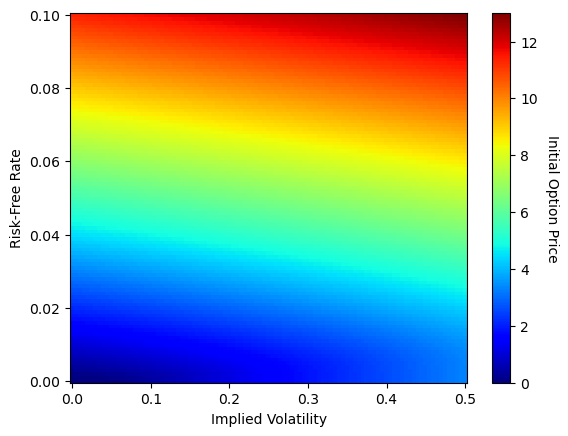

In [11]:
_ = plt.pcolor(volatility, risk_free_rate, option_price_arr, cmap='jet')
_ = plt.xlabel('Implied Volatility')
_ = plt.ylabel('Risk-Free Rate')
cbar = plt.colorbar()
cbar.set_label('Initial Option Price', rotation=270, labelpad=15)

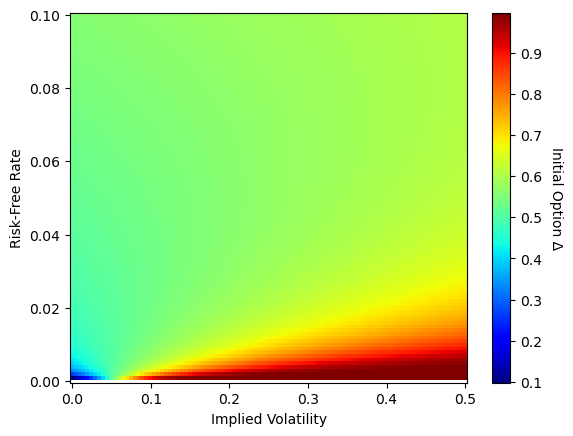

In [12]:
_ = plt.pcolor(volatility, risk_free_rate, delta_arr, cmap='jet')
_ = plt.xlabel('Implied Volatility')
_ = plt.ylabel('Risk-Free Rate')
cbar = plt.colorbar()
cbar.set_label('Initial Option \u0394', rotation=270, labelpad=15)

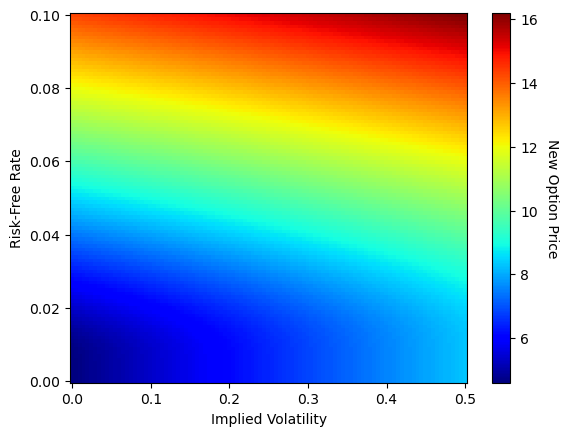

In [13]:
_ = plt.pcolor(volatility, risk_free_rate, new_option_price_arr, cmap='jet')
_ = plt.xlabel('Implied Volatility')
_ = plt.ylabel('Risk-Free Rate')
cbar = plt.colorbar()
cbar.set_label('New Option Price', rotation=270, labelpad=15)

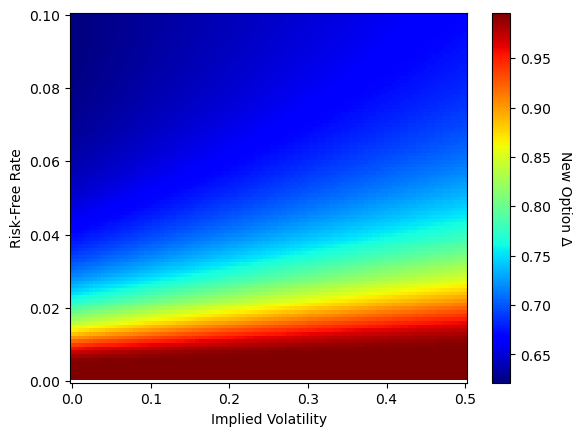

In [14]:
_ = plt.pcolor(volatility, risk_free_rate, new_delta_arr, cmap='jet')
_ = plt.xlabel('Implied Volatility')
_ = plt.ylabel('Risk-Free Rate')
cbar = plt.colorbar()
cbar.set_label('New Option \u0394', rotation=270, labelpad=15)

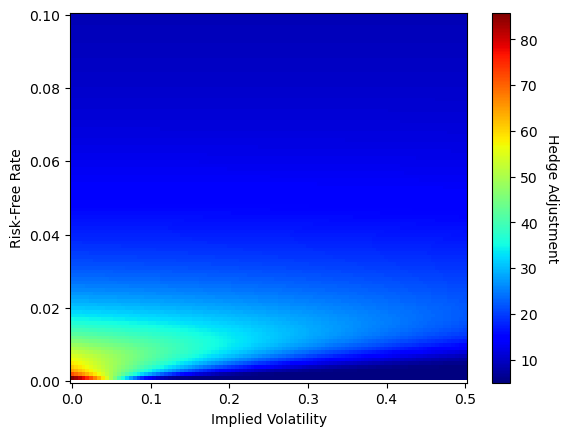

In [15]:
_ = plt.pcolor(volatility, risk_free_rate, hedge_adjustment_arr, cmap='jet')
_ = plt.xlabel('Implied Volatility')
_ = plt.ylabel('Risk-Free Rate')
cbar = plt.colorbar()
cbar.set_label('Hedge Adjustment', rotation=270, labelpad=15)

We can see from the plots that the option prices do show the linear relationship with both implied volatility and risk-free rate. The relationship of delta and the position adjustment is no as simple. The hedge adjustment is seen to be more sensitive at lower values of both volatility and risk-free rate, while being more stable at larger values.